<a href="https://colab.research.google.com/github/hzhe5009/CS36-Capstone-LSTM/blob/master/CS36_2_LSTM_Huixian_Zheng_480070588_ipynb%EF%BC%88finetuning%EF%BC%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, LeakyReLU,Dropout, LSTM, concatenate,Input
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from datetime import datetime, timedelta, time
import random
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# define model
model = Sequential()
model.add(LSTM(512, batch_input_shape=(None, 45, 32+7+25+60+265+1)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))
model.add(Dense(265))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))
model.add(Dense(32))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))
model.add(Dense(1, activation='relu'))
print(model.summary())

adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
# compile the model
model.compile(loss='mean_squared_error', metrics=['mse', 'mae', 'mape'], optimizer=adam)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 512)               1849344   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 265)               1

In [0]:
data_path = '/content/gdrive/My Drive/ctx/combine_data/partzone3month.csv'
new_select_data = pd.read_csv(data_path)



In [0]:
new_select_data['pickup_time_g_index'] = pd.to_datetime(new_select_data['pickup_time_g']) #, format='%Y/%m/%d %I:%M:%S %p', errors='ignore')
new_select_data['pickup_time_g'] = new_select_data['pickup_time_g_index'].copy()
new_select_data.set_index('pickup_time_g_index',inplace=True)
split_size = 4000
num_epochs = 5
loop_list = random.sample(range(0, split_size), int(split_size/100))
new_select_grouper = new_select_data.groupby('LocationID')
del new_select_data

In [0]:
split_list ={}
val_loss = 0

for i in loop_list:
  train_data,label_data = [],[]
  for each_loc in new_select_grouper:
    location_data = each_loc[1]
    if i == loop_list[0]:
      random_location_data = location_data.sample(frac=1, random_state=2020)
      split_list[each_loc[0]]  = np.array_split(random_location_data, split_size)
    location_df_list = split_list[each_loc[0]] 
    first_time = True
    for index, row in location_df_list[i].iterrows():
      this_time = row['pickup_time_g']
      time_window = (location_data['pickup_time_g']>=this_time - timedelta(minutes=45))&(location_data['pickup_time_g']<=this_time - timedelta(minutes=1))
      window_items = location_data[time_window]
      if len(window_items) ==  45:
          pu_day_cat = to_categorical(window_items['day'], num_classes=32)
          pu_week_cat = to_categorical(window_items['weekday'], num_classes=7)
          hour_cat = to_categorical(window_items['hour'], num_classes=25)
          minute_cat = to_categorical(window_items['minute'], num_classes=60)
          if first_time:
            first_time = False
            locat_cat = to_categorical(window_items['LocationID'], num_classes=265)
          train_data.append(np.hstack((pu_day_cat,pu_week_cat,hour_cat,minute_cat,locat_cat,
                                      window_items['minute_demand'].values.reshape(-1,1))))
          label_data.append(row['15_demand'])
  
  train_data = np.array(train_data)
  label_data = np.array(label_data)
  X_tr, X_val, y_tr, y_val = train_test_split(train_data, label_data, test_size=0.1, random_state=2020)
  history = model.fit(X_tr, y_tr, epochs=1, verbose=2,validation_data=(X_val, y_val))
  val_loss +=  model.evaluate(X_val, y_val, verbose=2)[-2]


122/122 - 39s - loss: 551.0303 - mse: 551.0229 - mae: 9.8755 - mape: 290600960.0000 - val_loss: 60.2607 - val_mse: 61.1231 - val_mae: 3.5314 - val_mape: 336434656.0000
14/14 - 1s - loss: 60.2607 - mse: 61.1231 - mae: 3.5314 - mape: 336434656.0000
118/118 - 35s - loss: 167.4003 - mse: 167.5484 - mae: 5.5688 - mape: 340001952.0000 - val_loss: 76.7657 - val_mse: 81.3977 - val_mae: 4.3685 - val_mape: 370087680.0000
14/14 - 1s - loss: 76.7657 - mse: 81.3977 - mae: 4.3685 - mape: 370087680.0000
118/118 - 35s - loss: 123.5002 - mse: 123.5991 - mae: 4.6648 - mape: 218066992.0000 - val_loss: 43.9631 - val_mse: 46.6774 - val_mae: 3.1125 - val_mape: 166746448.0000
14/14 - 1s - loss: 43.9631 - mse: 46.6774 - mae: 3.1125 - mape: 166746448.0000
118/118 - 35s - loss: 93.2099 - mse: 93.1254 - mae: 4.2988 - mape: 205992992.0000 - val_loss: 50.7179 - val_mse: 53.7867 - val_mae: 3.1969 - val_mape: 139036496.0000
14/14 - 1s - loss: 50.7179 - mse: 53.7867 - mae: 3.1969 - mape: 139036496.0000
118/118 - 35s 

In [0]:
print(val_loss/len(loop_list))

3.078838747739792


In [0]:
# evaluate the model
val_metric = model.evaluate(X_tr, y_tr, verbose=2)
val_metric = model.evaluate(X_val, y_val, verbose=2)
print(val_metric)

118/118 - 10s - loss: 28.9225 - mse: 28.9519 - mae: 2.5114 - mape: 54113184.0000
14/14 - 1s - loss: 43.8510 - mse: 45.6363 - mae: 2.8524 - mape: 54539972.0000
[43.850975036621094, 45.636314392089844, 2.8524367809295654, 54539972.0]


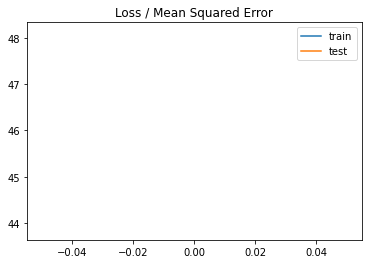

In [0]:
# plot loss during training
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
del history
del split_list
del new_select_grouper

In [0]:
data_path = '/content/gdrive/My Drive/ctx/combine_data/2019test/All_Demand_2019_3months.csv'
new_select_data = pd.read_csv(data_path)

new_select_data['pickup_time_g_index'] = pd.to_datetime(new_select_data['pickup_time_g']) #, format='%Y/%m/%d %I:%M:%S %p', errors='ignore')
new_select_data['pickup_time_g'] = new_select_data['pickup_time_g_index'].copy()
new_select_data.set_index('pickup_time_g_index',inplace=True)
new_select_grouper = new_select_data.groupby('LocationID')
train_data, label_data = [],[]
for each_loc in new_select_grouper:
  location_data = each_loc[1]
  first_time = True
  location_data_sample = location_data.sample(frac=0.001, random_state=2020)
  for index, row in location_data_sample.iterrows():
    this_time = row['pickup_time_g']
    time_window = (location_data['pickup_time_g']>=this_time - timedelta(minutes=45))&(location_data['pickup_time_g']<=this_time - timedelta(minutes=1))
    window_items = location_data[time_window]
    if len(window_items) == 45:
        pu_day_cat = to_categorical(window_items['day'], num_classes=32)
        pu_week_cat = to_categorical(window_items['weekday'], num_classes=7)
        hour_cat = to_categorical(window_items['hour'], num_classes=25)
        minute_cat = to_categorical(window_items['minute'], num_classes=60)
        if first_time:
          first_time = False
          locat_cat = to_categorical(window_items['LocationID'], num_classes=265)
        train_data.append(np.hstack((pu_day_cat,pu_week_cat,hour_cat,minute_cat,locat_cat,
                                    window_items['minute_demand'].values.reshape(-1,1))))
        label_data.append(row['15_demand'])


train_data = np.array(train_data)
label_data = np.array(label_data)
X_tr, X_val, y_tr, y_val = train_test_split(train_data, label_data, test_size=0.1, random_state=2020)

In [0]:
test_metric = model.evaluate(X_val, y_val, verbose=2)
print(test_metric)

53/53 - 5s - loss: 24.1127 - mse: 24.3388 - mae: 2.3704 - mape: 84099960.0000
[24.112661361694336, 24.33879280090332, 2.370351791381836, 84099960.0]
